<a href="https://colab.research.google.com/github/nhuang37/untrain_MPNN/blob/main/Untrain_MPNN_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [1]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/JHU/Untrain_GNN/

/content/drive/MyDrive/JHU/Untrain_GNN


In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import math
import random
import os
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
from sklearn import svm, manifold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.cluster import KMeans

import pickle
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset, zinc
from torch_geometric.utils import to_networkx, homophily, erdos_renyi_graph, stochastic_blockmodel_graph
from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool
from torch.nn import Linear, Sequential, ReLU, Dropout
import torch_geometric.transforms as T

import time
from scipy.sparse.linalg import eigsh, eigs
import pandas as pd
import seaborn as sns

### Models

In [5]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [6]:
class GIN(nn.Module):
    def __init__(self, input_dim, hid_dim, num_layers):
        super(GIN, self).__init__()
        self.conv_in = GINConv( Sequential(Linear(input_dim, hid_dim), ReLU(),
                       Linear(hid_dim, hid_dim), ReLU()  ))
        self.convs = nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append( GINConv( Sequential(Linear(hid_dim, hid_dim), ReLU(),
                       Linear(hid_dim, hid_dim), ReLU() )) )

        self.reset_parameters()

    def reset_parameters(self):
        self.conv_in.reset_parameters()
        for layer in self.convs:
            layer.reset_parameters()


    def forward(self, data):
        x, edge_index, batch_index = data.x, data.edge_index, data.batch

        x = self.conv_in(x, edge_index)
        x = F.relu(x)

        #x = F.dropout(x, training=self.training)
        for layer in self.convs:
          x = layer(x, edge_index)
          x = F.relu(x)

        #  Readout layer
        x = global_add_pool(x, batch_index) #global_mean_pool - GCN, less powerful

        return x 

In [7]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim, n_layers, dropout):
        super(FeedForwardNet, self).__init__()
        self.layers = nn.ModuleList()
        self.n_layers = n_layers
        self.drop_prop = dropout
        if n_layers == 1:
            self.layers.append(nn.Linear(input_dim, out_dim))
        else:
            self.layers.append(nn.Linear(input_dim, hid_dim))
            for i in range(n_layers - 2):
                self.layers.append(nn.Linear(hid_dim, hid_dim))
            self.layers.append(nn.Linear(hid_dim, out_dim))
        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain("relu")
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight, gain=gain)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer_id, layer in enumerate(self.layers):
            x = layer(x)
            if layer_id < self.n_layers - 1:
              if self.drop_prop > 0:
                x = self.dropout(F.relu(x))
              else:
                x = F.relu(x)
        return x

In [8]:
class Net(nn.Module):
  def __init__(self, GNN, classifier):
    super(Net, self).__init__()
    self.GNN = GNN
    self.classifier = classifier

  def reset_parameters(self):
    for (name, module) in self._modules.items():
        module.reset_parameters()

  def forward(self, x):
    embed = self.GNN(x)
    pred = self.classifier(embed)
    return pred

### Real-world experiments: GIN on TUDataset (10 runs)

| MUTAG | #params (K) |Accuracy ($\pm$ std) 
| --- | --- | --- |
| Trained | 16.898 | 0.88 (0.12)
| Untrained | 4.290 | 0.87 (0.11)


---

| PROTEINS | #params (K) |Accuracy ($\pm$ std) 
| --- | --- | --- |
| Trained | 16.898 | 0.72 (0.04)
| Untrained | 4.290 | 0.70 (0.03)

---



| IMDB-BINARY | #params (K) |Accuracy ($\pm$ std) 
| --- | --- | --- |
| Trained | 16.898 | 0.70 (0.05)
| Untrained | 4.290 | 0.69 (0.03)

In [9]:
def train(model, epoch, loader, optimizer, loss_fcn, device):
    model.train()
    loss_all = 0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_fcn(model(data), data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(loader.dataset)


def test(model, loader, device):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data).max(1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct /len(loader.dataset)

In [10]:
def train_test_split(dataset, n_runs):
    '''
    Obtain n_runs of train/valid/test dataset splits (masks)
    '''
    train_masks, val_masks, test_masks = [], [], []
    for i in range(n_runs):
      test_mask = torch.zeros(len(dataset), dtype=torch.bool)
      n = len(dataset) // 10
      test_mask[i * n:(i + 1) * n] = 1
      train_dataset = dataset[~test_mask]
      n = len(train_dataset) // 10
      val_mask = torch.zeros(len(train_dataset), dtype=torch.bool)
      val_mask[i * n:(i + 1) * n] = 1
      train_mask = ~val_mask
      train_masks.append(train_mask)
      val_masks.append(val_mask)
      test_masks.append(test_mask)
    return train_masks, val_masks, test_masks

In [18]:
def MC_run(dataset, train_masks, val_masks, test_masks, num_epochs = 200, BATCH = 32, lr = 0.01, untrain = True,
           input_dim = 1, hid_dim = 64, out_dim = 2, num_layers = 2, dropout = 0.5, verbose = True):
  '''
  Run (untrained) MPNN on graph classification tasks based on different train/valid/test splits
  dataset: Pytorch Geometric dataset
  train_masks, val_masks, test_masks: a list of n_runs elements, with each element being a binary mask of length len(dataset)
  '''
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  GNN_block = GIN(input_dim=input_dim, hid_dim=hid_dim, num_layers=num_layers)
  if untrain:
    for param in GNN_block.parameters():
      param.requires_grad = False

  Classifier = FeedForwardNet(input_dim=hid_dim, hid_dim=hid_dim, out_dim=out_dim, n_layers=num_layers, dropout=dropout)
  model = Net(GNN_block, Classifier).to(device)

  loss_fcn = nn.CrossEntropyLoss()
  acc = []
  n_runs = len(train_masks)
  for i in range(n_runs):
      model.reset_parameters()
      model_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
      print(f"untrain={untrain}, trainable_params={model_train_params}")
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

      test_dataset = dataset[test_masks[i]]
      train_dataset = dataset[~test_masks[i]]
      val_dataset = train_dataset[val_masks[i]]
      train_dataset = train_dataset[train_masks[i]]
      val_loader = DataLoader(val_dataset, batch_size=BATCH)
      test_loader = DataLoader(test_dataset, batch_size=BATCH)
      train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

      if verbose:
          print('---------------- Split {} ----------------'.format(i))

      best_val_acc, best_test_acc = 0, 0
      for epoch in range(1, num_epochs+1):
          train_loss = train(model, epoch, train_loader, optimizer, loss_fcn, device)
          scheduler.step()

          val_acc = test(model, val_loader, device)
          test_acc = test(model, test_loader, device)
          if verbose and epoch % 50 == 0:
              print(f'Epoch:{epoch:03d}, Train_loss: {train_loss:.4f}, Val_acc: {val_acc:.4f}, Test_acc: {test_acc:.4f}')
          if best_val_acc <= val_acc:
              best_test_acc = test_acc
              best_val_acc = val_acc
      acc.append(best_test_acc)
  acc = torch.tensor(acc)
  print('---------------- Final Result ----------------')
  print('Mean: {:7f}, Std: {:7f}'.format(acc.mean(), acc.std()))
  return acc

In [12]:
class MyPreTransform(object):
    def __call__(self, data):
        data.x = torch.ones((data.num_nodes, 1), dtype=torch.float)
        return data

In [16]:
def main_TUD(data_name='MUTAG', folder_name='./dataset/MUTAG-nofeat', n_runs=10, lr=0.01, num_epochs=200, seed=999, verbose=False):
  '''
  Main function call to run experiments on TUD datasets
  '''
  seed_everything(seed)
  dataset = TUDataset(root=folder_name, name=data_name,  use_node_attr=True, pre_transform=T.Compose([MyPreTransform()]))
  dataset = dataset.shuffle()
  train_masks, val_masks, test_masks = train_test_split(dataset, n_runs)
  out_dim = len(dataset.data.y.unique())
  #print(out_dim)
  acc_trained = MC_run(dataset, train_masks, val_masks, test_masks, num_epochs, out_dim=out_dim, lr=lr, untrain=False, verbose=verbose)
  acc_untrain = MC_run(dataset, train_masks, val_masks, test_masks, num_epochs, out_dim=out_dim, lr=lr, untrain=True, verbose=verbose)
  return acc_trained, acc_untrain

#### MUTAG

In [19]:
acc_mutag, acc_untrain_mutag = main_TUD(data_name='MUTAG', folder_name='./dataset/MUTAG-nofeat', n_runs=10, seed=99, verbose=True)

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


untrain=False, trainable_params=16898
---------------- Split 0 ----------------
Epoch:050, Train_loss: 0.4881, Val_acc: 0.8824, Test_acc: 0.9444
Epoch:100, Train_loss: 0.4403, Val_acc: 0.5882, Test_acc: 0.7222
Epoch:150, Train_loss: 0.4201, Val_acc: 0.8235, Test_acc: 0.8889
Epoch:200, Train_loss: 0.3463, Val_acc: 0.8235, Test_acc: 0.8889
untrain=False, trainable_params=16898
---------------- Split 1 ----------------
Epoch:050, Train_loss: 0.5182, Val_acc: 0.8824, Test_acc: 0.8333
Epoch:100, Train_loss: 0.3434, Val_acc: 1.0000, Test_acc: 0.7778
Epoch:150, Train_loss: 0.3367, Val_acc: 1.0000, Test_acc: 0.7778
Epoch:200, Train_loss: 0.3171, Val_acc: 1.0000, Test_acc: 0.7778
untrain=False, trainable_params=16898
---------------- Split 2 ----------------
Epoch:050, Train_loss: 0.5146, Val_acc: 0.9412, Test_acc: 1.0000
Epoch:100, Train_loss: 0.4731, Val_acc: 0.9412, Test_acc: 1.0000
Epoch:150, Train_loss: 0.3813, Val_acc: 0.9412, Test_acc: 1.0000
Epoch:200, Train_loss: 0.3570, Val_acc: 0.823

#### PROTEINS

In [36]:
acc_p, acc_untrain_p = main_TUD(data_name='PROTEINS', folder_name='./dataset/PROTEINS-nofeat', lr=0.01, num_epochs=300, 
                                          n_runs=10, seed=99, verbose=False)

2
trainable_params=16898
---------------- Final Result ----------------
Mean: 0.719820, Std: 0.040613
trainable_params=4290
---------------- Final Result ----------------
Mean: 0.701802, Std: 0.034619


#### IMDB-BINARY

In [47]:
acc_imdb, acc_untrain_imdb = main_TUD(data_name='IMDB-BINARY', folder_name='./dataset/IMDB-nofeat', lr=0.001, num_epochs=200, 
                                          n_runs=10, seed=99, verbose=False)

2
trainable_params=16898
---------------- Final Result ----------------
Mean: 0.696000, Std: 0.046951
trainable_params=4290
---------------- Final Result ----------------
Mean: 0.693000, Std: 0.033015


### Simulation: SBM(p,q)
- easy: p = q (i.e., Erdos-Renyi graph); p >> q
- hard: p = q; p ~= q

In [48]:
#config
num_graphs = 100
n = 50
p = 0.5
qs = [0.1, 0.3, 0.4, 0.45]
ER_set, SBM_dicts = [], {0.1:[], 0.3:[], 0.4:[], 0.45:[]}
#constant node features
x = torch.ones((n, 1), dtype=torch.float)
#simulate graphs
for i in range(num_graphs):
  ER_set.append(Data(x=x, edge_index=erdos_renyi_graph(n, p, directed=False), y=torch.zeros(1)))
  for q in qs:
    SBM_dicts[q].append(
        Data(x=x, edge_index=stochastic_blockmodel_graph([n//2, n//2], [[p, q],[q, p]], directed=False),
            y=torch.ones(1)))


In [49]:
#data loader
ER_set = DataLoader(ER_set, batch_size=num_graphs)
for key, val in SBM_dicts.items():
  SBM_dicts[key] = DataLoader(val, batch_size=num_graphs)


In [50]:
#untrain GNN
input_dim = 1 
hid_dim = 32
num_layers = 2
GNN_block = GIN(input_dim=input_dim, hid_dim=hid_dim, num_layers=num_layers)
for param in GNN_block.parameters():
  param.requires_grad = False

In [51]:
#forward pass: obtain untrained graph embedding
for data in ER_set:
  embed_ER = GNN_block(data)

embed_SBMs = {}

for key, loader in SBM_dicts.items():
  for data in loader:
    embed_SBMs[key] = GNN_block(data)
#post-processing
embed_pairs = {}
for key, embed in embed_SBMs.items():
  embed_pairs[key] = np.vstack( (embed_ER.numpy(), embed.numpy()) )  

In [54]:
#Classification
kmeans = KMeans(
    n_clusters=2,
    max_iter=100,
    n_init=5,
)

In [55]:
labels = np.hstack( (np.zeros(num_graphs), np.ones(num_graphs)) )
ARIs = []
for key, pair in embed_pairs.items():
  kmeans.fit(pair)
  ARI = adjusted_rand_score(labels, kmeans.labels_)
  ARIs.append(ARI)
  print(f"q={key}: ARI={ARI}")

q=0.1: ARI=1.0
q=0.3: ARI=1.0
q=0.4: ARI=0.9020080211756614
q=0.45: ARI=0.39390577268909877


In [56]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)
embed_easy = t_sne.fit_transform(embed_pairs[0.1])
embed_hard = t_sne.fit_transform(embed_pairs[0.45])


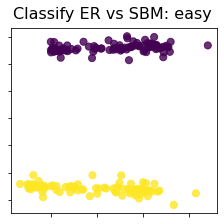

In [59]:
colors = np.vstack( (np.zeros(num_graphs), np.ones(num_graphs)) )
fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
fig.suptitle("Classify ER vs SBM: easy", size=16)

ax.scatter(embed_easy[:,0], embed_easy[:,1], c=colors, s=50, alpha=0.8)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_formatter(ticker.NullFormatter())

plt.show()


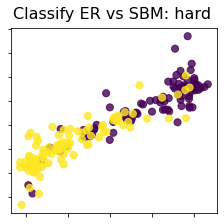

In [60]:
fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
fig.suptitle("Classify ER vs SBM: hard", size=16)

ax.scatter(embed_hard[:,0], embed_hard[:,1], c=colors, s=50, alpha=0.8)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_formatter(ticker.NullFormatter())

plt.show()

Remarks:
- Different from SGC/power-iteration: essentially simulate WL algorithm, so the MLP per layer is needed to simulate injective map (although such MLPs do not need to be trained in order to preserve injectiveness!)

- Different from random feature initialization; here we assume constant feature but use random weights